In [1]:
#Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


c:\Users\raxo1\anaconda3\envs\TIL_programming\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Import of prestation data ---

#Read the data
df_pres = pd.read_csv('data/transport_performance.csv', sep=';')

#Initialise prestation data
df_pres['Periods'] = pd.to_numeric(df_pres['Periods'], errors='coerce')
df_pres['Transport performance (billion passenger kilometres )'] = pd.to_numeric(df_pres['Transport performance (billion passenger kilometres )'], errors='coerce')

#Rename columns
df_pres.rename({'Transport performance (billion passenger kilometres )': 'Total travel'}, axis=1, inplace=True)

#Drop unnesecary columns
df_pres.drop('Margins', axis=1, inplace=True)
df_pres.drop('Population', axis=1, inplace=True)

df_pres.head()


,Modes of travel,Region characteristics,Periods,Total travel
0,Total,The Netherlands,2018,218.1
1,Total,The Netherlands,2019,218.8
2,Total,The Netherlands,2020,152.0
3,Total,The Netherlands,2021,168.4
4,Total,The Netherlands,2022,186.9


In [3]:
# --- Import of mobility data ---

df_mob = pd.read_csv('data/mobility_trends.csv', sep=';')

#initialise data

df_mob.head()


,Sex,Age,Modes of travel,Travel motives,Margins,Periods,Stages per person per day (average) (number),Distance travelled per stage (average) (passenger kilometres),Average travel time per stage (Minutes)
0,Total male and female,Total,Total,Total,Value,1999*,3.41,10.96,23.72
1,Total male and female,Total,Total,Total,Value,2000*,3.35,11.00,23.73
2,Total male and female,Total,Total,Total,Value,2001*,3.30,10.99,23.67
3,Total male and female,Total,Total,Total,Value,2002*,3.30,11.01,23.49
4,Total male and female,Total,Total,Total,Value,2003*,3.30,11.04,23.65


In [43]:
# --- Model 1 forecasting ---

#Create dataframe for model 1
df_m1 = df_mob[(df_mob['Modes of travel']=='Total') & (df_mob['Travel motives']== 'Total')].copy()

df_m1['ds'] = df_m1['Periods'].str[:-1] + '-01-01'
df_m1['ds'] = pd.to_datetime(df_m1['ds'])

df_m1['y'] = df_m1['Stages per person per day (average) (number)'].astype(float) * df_m1['Distance travelled per stage (average) (passenger kilometres)'].astype(float)

#Add regressor to dataframe to include covid as special event
df_m1['covid'] = 0
df_m1.loc[(df_m1['Periods'] == 2020), 'covid'] = 1
df_m1.loc[(df_m1['Periods'] == 2021), 'covid'] = 0.5

#Forecast the first model using prophet
m1 = Prophet(changepoint_prior_scale=0.5)
m1.add_regressor('covid')
m1.fit(df_m1)
prediction_m1 = m1.make_future_dataframe(periods=5, freq='YE')
prediction_m1['covid'] = 0

forecast_m1 = m1.predict(prediction_m1)

C:\Users\raxo1\AppData\Local\Temp\ipykernel_23384\329986330.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_m1.loc[(df_m1['Periods'] == 2021), 'covid'] = 0.5
11:07:32 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] done processing


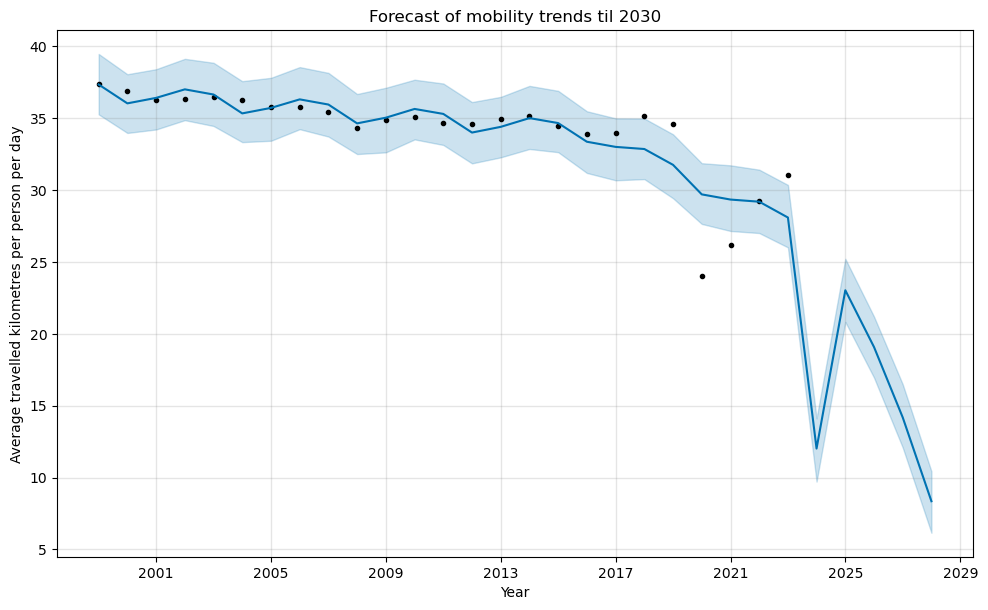

In [44]:
# --- Plot results of forecast model 1 ---
fig1 = m1.plot(forecast_m1)
plt.title('Forecast of mobility trends til 2030')
plt.ylabel('Average travelled kilometres per person per day')
plt.xlabel('Year')
plt.show()


In [29]:
# --- Evaluate model 1 ---

#Do cross_validation to check accuracy of model
df_cv_m1 = cross_validation(
    model=m1,
    initial='365 D',
    period='730 D',
    horizon='365 D'
)

df_p_m1 = performance_metrics(df_cv_m1)

#Print results of performance metrics
print("\nPerformance Metrics head:")
print(df_p_m1.head())

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]10:56:53 - cmdstanpy - INFO - Chain [1] start processing
10:56:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.44it/s]10:56:54 - cmdstanpy - INFO - Chain [1] start processing
10:57:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:12<01:13,  7.37s/it]10:57:06 - cmdstanpy - INFO - Chain [1] start processing
10:57:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:25<01:28,  9.83s/it]10:57:18 - cmdstanpy - INFO - Chain [1] start processing
10:57:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:39<01:31, 11.41s/it]10:57:32 - cmdstanpy - INFO - Chain [1] start processing
10:57:48 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:55<01:31, 13.09s/it]10:57:48 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:55<00:52,  8.83s/it]10:57:49


Performance Metrics head:
   horizon         mse       rmse       mae      mape     mdape     smape  \
0 360 days  166.507149  12.903765  9.146520  0.252197  0.252197  0.336771   
1 361 days    0.059949   0.244845  0.217605  0.006100  0.006100  0.006076   
2 362 days    0.977749   0.988812  0.814637  0.023381  0.023381  0.023764   
3 363 days    0.450285   0.671033  0.670214  0.019327  0.019327  0.019345   
4 364 days    0.045722   0.213828  0.189703  0.005567  0.005567  0.005551   

   coverage  
0       0.5  
1       0.0  
2       0.0  
3       0.0  
4       0.5  


In [57]:
# --- Model 2 forecasting ---

#Restructing of data
df_m2 = df_pres[(df_pres['Modes of travel']=='Total') & (df_pres['Region characteristics']=='The Netherlands')].copy()
df_m2 = df_m2.rename(columns={'Total travel': 'y'})

df_m2['ds'] = df_m2['Periods'].astype(str) + '-01-01'
df_m2['ds'] = pd.to_datetime(df_m2['ds'])

#Add covid as an event to the model
df_m2['covid'] = 0
df_m2.loc[(df_m2['Periods'] == 2020), 'covid'] = 1
df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5

#Fit the model
m2 = Prophet(changepoint_prior_scale=0.5)
m2.add_regressor('covid')
m2.fit(df_m2)

#Predict future
prediction_m2 = m2.make_future_dataframe(periods=7, freq='YE')
prediction_m2['covid'] = 0
forecast_m2 = m2.predict(prediction_m2)

C:\Users\raxo1\AppData\Local\Temp\ipykernel_23384\661557165.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5
11:14:25 - cmdstanpy - INFO - Chain [1] start processing
11:14:30 - cmdstanpy - INFO - Chain [1] done processing


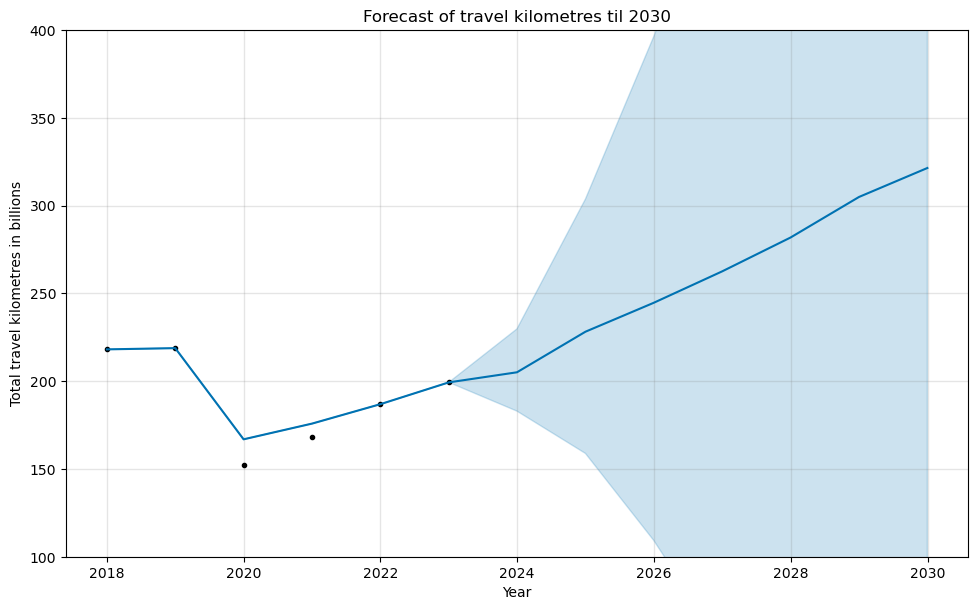

In [58]:
# --- Plot results of model 2 forecast ---

fig2 = m2.plot(forecast_m2)
ax1 = fig2.gca()

ax1.set_ylim(100, 400)
plt.title('Forecast of travel kilometres til 2030')
plt.ylabel('Total travel kilometres in billions')
plt.xlabel('Year')
plt.show()

In [59]:
# --- Evaluate model 2 ---

df_cv_m2 = cross_validation(
    model=m2,
    initial='365 D',
    period='730 D',
    horizon='365 D'
)

print(df_cv_m2.head())

df_p_m2 = performance_metrics(df_cv_m2)

print("\nPerformance Metrics head:")
print(df_p_m2.head())

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:04<00:04,  4.94s/it]11:14:37 - cmdstanpy - INFO - Chain [1] start processing
11:14:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:10<00:00,  5.10s/it]

          ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 2021-01-01  -35.247964  -36.757567  -33.573837  168.4 2020-01-02
1 2023-01-01  172.151635  168.672512  175.798095  199.3 2022-01-01

Performance Metrics head:
   horizon           mse        rmse         mae      mape     mdape  \
0 365 days  21104.763426  145.274786  115.398164  0.672765  0.672765   

      smape  coverage  
0  1.073087       0.0  
